In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
smiles_and_names[0]

('COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O',
 '5-hydroxy-6-(methoxymethyl)-2-(4-methoxyphenyl)-8-methyl-7-{[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-2,3-dihydro-1-benzopyran-4-one',
 506.5040000000003,
 'dataset_train_1d')

In [4]:
from inference.inference_utils import choose_model
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [5]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model, test_loader = choose_model("optional", return_test_loader=True)

max_radius = fp_loader.max_radius




Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [6]:
# fp_loader.setup(max_radius=6, out_dim = 16384)
# max_radius = fp_loader.max_radius
# hparams = {'out_dim': 16384}


In [7]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [8]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

In [9]:
# for idx, batch in enumerate(test_loader):
       
#         inputs, extra_info = batch
#         (smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
#         if (smiles[0]) == "COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3":
#             print("Found the molecule")
#             print(idx)
#             break


############################################### compound number: 6##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.9845024943351746
Ground Truth NMR and structure


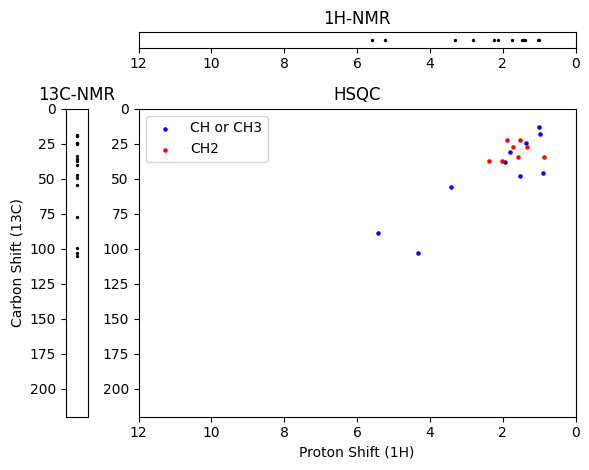

Ground truth chemical name Artemether (SM-224)
Ground truth SMILES COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3


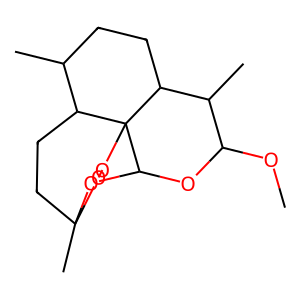

pred FP:         [[0], [2], [4], [5], [7], [14], [15], [18], [26], [37], [41], [49], [65], [106], [179], [329], [380], [411], [419], [560], [2297], [2755], [3072], [4127], [4431], [4643], [8796], [15585]]
________retival #1, cosine similarity to prediction: 0.9845024347305298_________________
retrival is the same as ground truth: True
ground truth FP [[0], [2], [4], [5], [7], [14], [15], [18], [26], [37], [41], [49], [65], [106], [179], [329], [380], [411], [419], [560], [2297], [3072], [4127], [4431], [4643], [8796], [15585]]
retrived FP     [[0], [2], [4], [5], [7], [14], [15], [18], [26], [37], [41], [49], [65], [106], [179], [329], [380], [411], [419], [560], [2297], [3072], [4127], [4431], [4643], [8796], [15585]]
SMILES: COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3
Name Artemether


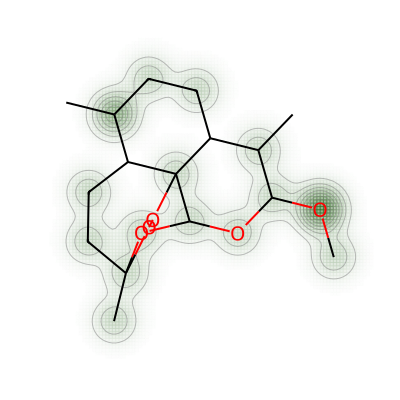

DONE






In [10]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''
from datasets.dataset_utils import  plot_NMR
from inference.inference_utils import show_retrieved_mol_with_highlighted_frags

# model.to("cuda")
# for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=1):# range(0, 1):  
for which_compound in [5]:    
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles[0])
    cos_ground_and_pred = compute_cos_sim(ground_truth_FP, pred.squeeze().float().to(ground_truth_FP.device))
    if cos_ground_and_pred < 1:
        print(f"############################################### compound number: {which_compound+1}##############################################################")
        print("Ground truth cosine similarity to prediction(floating point number after sigmoid): ", cos_ground_and_pred)
        # print(inputs)
        
        print("Ground Truth NMR and structure")
        plot_NMR(hsqc, c_tensor, h_tensor)
        

        # # ground truth
        mol = Chem.MolFromSmiles(smiles[0])
        # mol = Chem.AddHs(mol)
        print(f"Ground truth chemical name {names[0]}")
        print(f"Ground truth SMILES {smiles[0]}")
        # print(f"Ground truth NMR path {path[0]}")
        img = Draw.MolToImage(mol, size=(300, 300))
        img.show()
        
        print(f"pred FP:        ", pred_FP.nonzero().tolist())
        
        topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
        i=0
        for value, (smile, name, _, _), retrieved_FP in topk:
            print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
            print(f"retrival is the same as ground truth: {smile == smiles[0]}")
            print("ground truth FP", ground_truth_FP.nonzero().tolist())
            # print("retrived FP", retrieved_FP.nonzero().tolist())
            print("retrived FP    ", retrieved_FP.to_dense().squeeze().nonzero().tolist())
            mol = Chem.MolFromSmiles(smile)

            print(f"SMILES: {smile}") 
            print(f"Name {name}")
            # img = Draw.MolToImage(mol)
            # img.show()
            img = show_retrieved_mol_with_highlighted_frags(pred_FP, smile)
            img.show()
            i+=1
        
print("DONE\n\n\n\n")
        



In [11]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [40]:
def draw_mol_from_dir(dir):
    """
    Draw the molecule from the directory
    """
    smiles_file = Path(dir) / "SMILES.txt"
    with open(smiles_file, "r") as f:
        smiles = f.read().strip()
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    display(img)
    
    return smiles, img

In [12]:
# look for the higher cos_sim possible in our dataset
from inference.inference_utils import show_retrieved_mol_with_highlighted_frags
def retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"retival #{i+1}, cosine similarity between retrieval and ground truth: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        # img = Draw.MolToImage(mol)
        img = show_retrieved_mol_with_highlighted_frags(groud_truth_FP[0], smile)
        img.show()
        
        # display(img)
        i+=1

In [13]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)


# Kavaratamide_A_bit_infos = count_circular_substructures(Kavaratamide_A_SMILES)

In [14]:
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


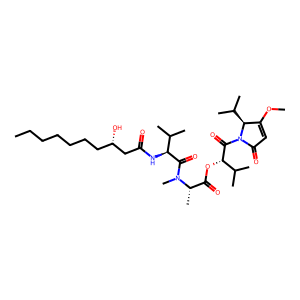

In [15]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img

retival #1, cosine similarity between retrieval and ground truth: 0.7378648519515991_____________________________
retrived FP [0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0,

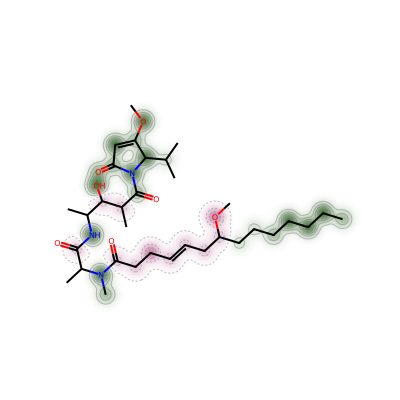

retival #2, cosine similarity between retrieval and ground truth: 0.6067880988121033_____________________________
retrived FP [0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.1714985966682434, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

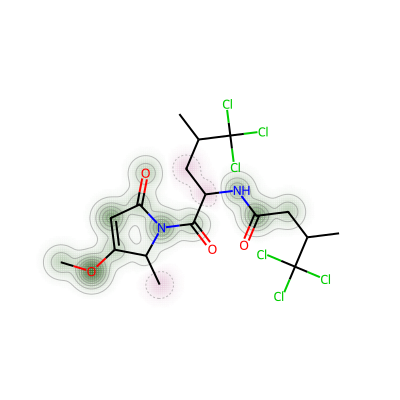

In [16]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7202965617179871



________retival #1, cosine similarity to prediction: 0.6675078868865967_________________
________retival's   cosine similarity to ground truth:  0.7378647923469543
________retival #1, cosine similarity to prediction: 0.6675078868865967_________________
________retival's   cosine similarity to ground truth:  0.7378647923469543
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name 934248-75-6


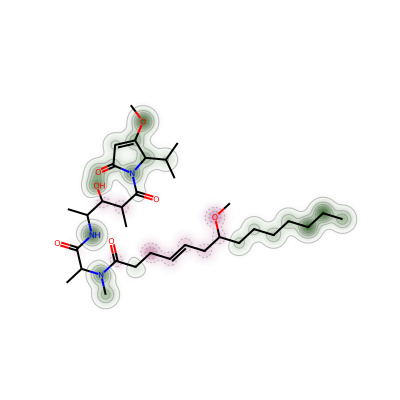

________retival #2, cosine similarity to prediction: 0.6392946243286133_________________
________retival's   cosine similarity to ground truth:  0.5570029616355896
________retival #2, cosine similarity to prediction: 0.6392946243286133_________________
________retival's   cosine similarity to ground truth:  0.5570029616355896
SMILES: CCCCCCC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)OC(C)=O
Name 139291778


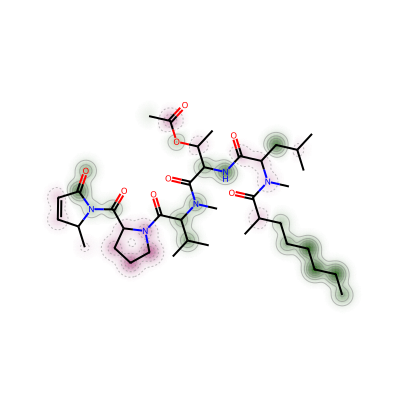

________retival #3, cosine similarity to prediction: 0.6229509115219116_________________
________retival's   cosine similarity to ground truth:  0.5227084755897522
________retival #3, cosine similarity to prediction: 0.6229509115219116_________________
________retival's   cosine similarity to ground truth:  0.5227084755897522
SMILES: CCCCC(C)CC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CC(O)CC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)O
Name 139291944


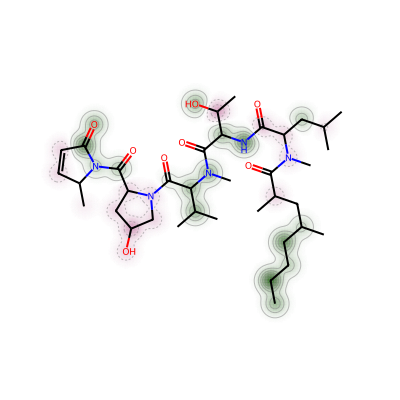

(['CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC',
  'CCCCCCC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)OC(C)=O',
  'CCCCC(C)CC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CC(O)CC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)O'],
 ['934248-75-6', '139291778', '139291944'])

In [20]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "DB_Specific_Radius", filter_by_MW="from_input",
                #    weight_pred = torch.tensor(-fp_loader.total_entropy_of_all_bits).to("cuda").float()
                )
                   

In [21]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model_DB_specific_FP(model_type)
        max_radius = fp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [22]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

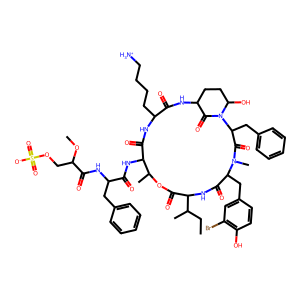

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [23]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

In [24]:
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

retival #1, cosine similarity between retrieval and ground truth: 0.8002593517303467_____________________________
retrived FP [0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086386844515800

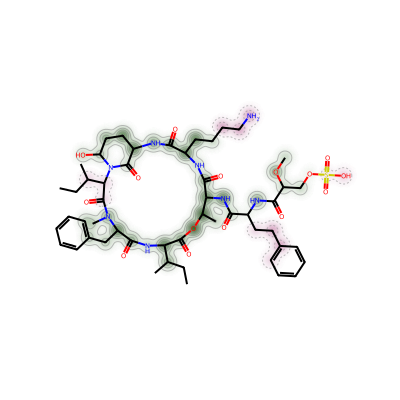

retival #2, cosine similarity between retrieval and ground truth: 0.7915244102478027_____________________________
retrived FP [0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

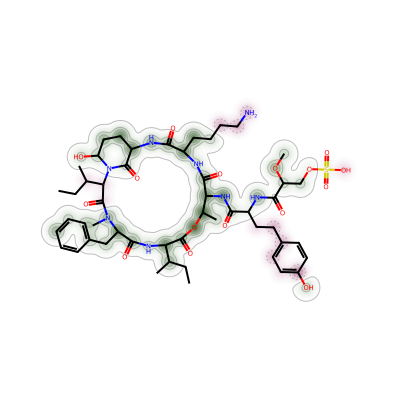

In [25]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.703415036201477



________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 49766272


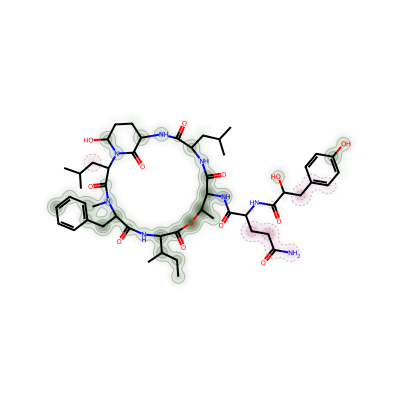

________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O
Name "[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"


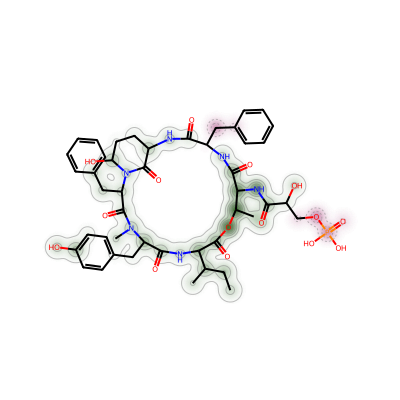

________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 102041486


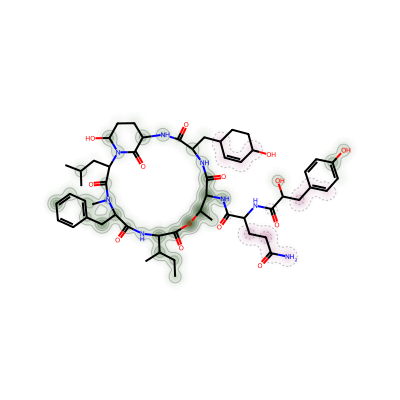

(['CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O'],
 ['49766272',
  '"[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"',
  '102041486'])

In [26]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [27]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




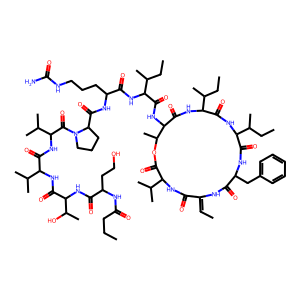

(['Oligopeptides'], False)

In [28]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

retival #1, cosine similarity between retrieval and ground truth: 0.9006819128990173_____________________________
retrived FP [0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356

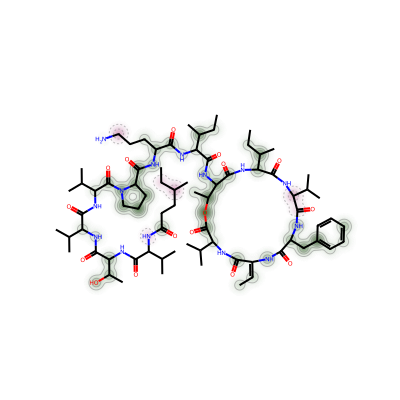

In [29]:
newCompoundB_FP = fp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7403514385223389



________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-

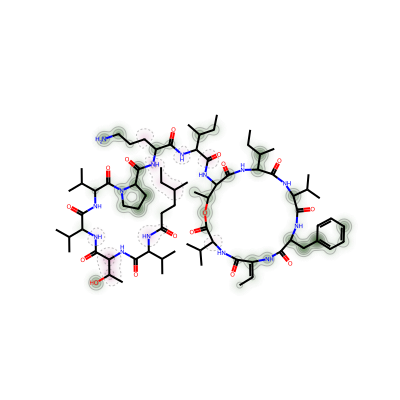

________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


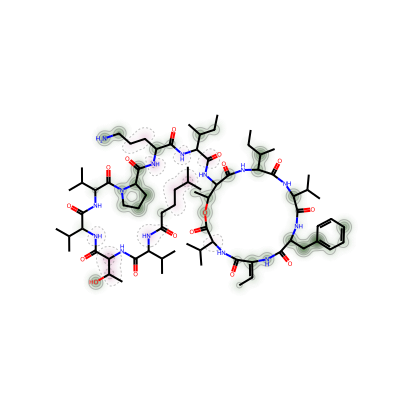

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"',
  '9898671'])

In [30]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.8439829349517822



________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


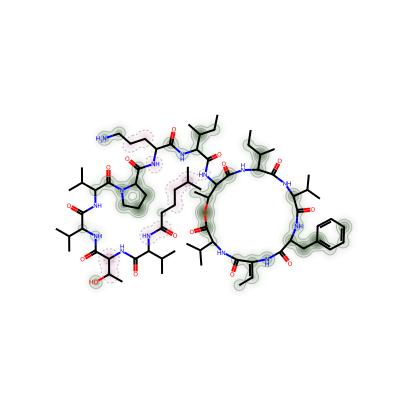

________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-but

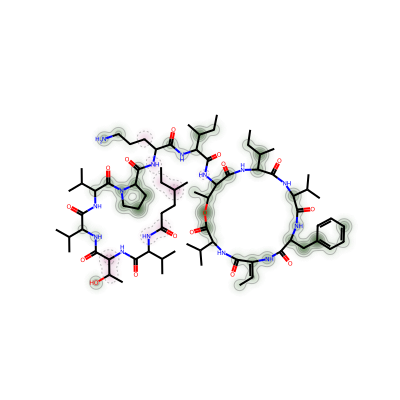

________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 5-OHKF


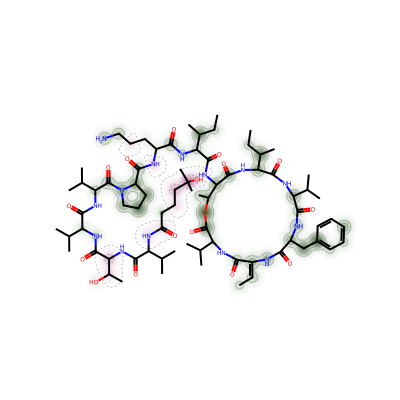

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['9898671',
  '"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methy

In [31]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [32]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [33]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)

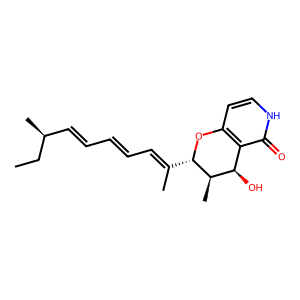




Aculeapyridone A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7674214243888855



________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
SMILES: CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C
Name YCM1008A


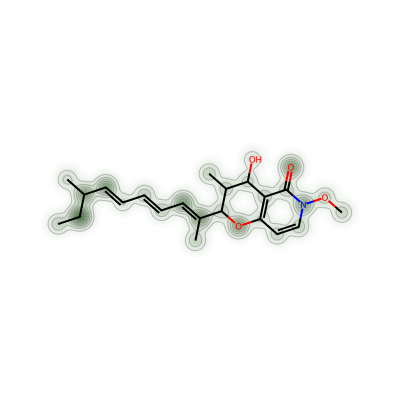

________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
SMILES: CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO
Name "4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"


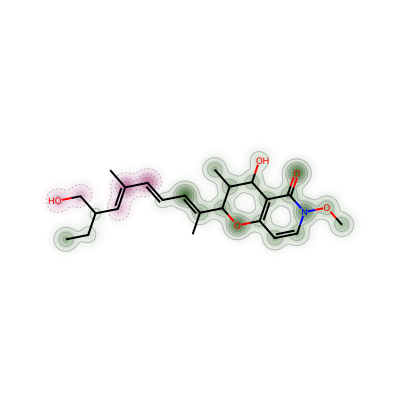

________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
SMILES: CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C
Name "(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"


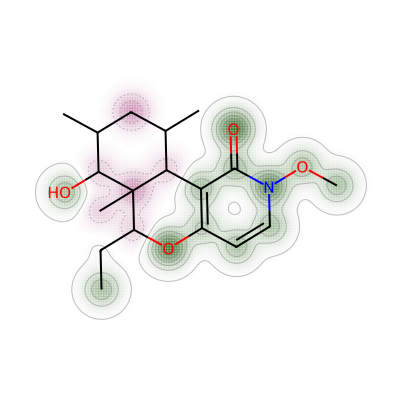

(['CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C',
  'CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO',
  'CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C'],
 ['YCM1008A',
  '"4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"',
  '"(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"'])

In [47]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Aculeapyridone A"

smiles, img = draw_mol_from_dir(compound_dir)

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles), filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")